<a href="https://colab.research.google.com/github/harmonydata/h_score/blob/main/experiment_with_different_h_score_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing on instrument level

Experimenting with metrics for an "H-score"

This would be a score that compares instrument similarity, e.g. the GAD-7 is x% similar overall to the PHQ-9

In [1]:
!pip install harmonydata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.9/423.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [25]:
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00


In [2]:
import harmony
from IPython.display import display, HTML
import numpy as np
from harmony import create_instrument_from_list
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/235M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

model_qint8_avx512.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

model_qint8_avx512_vnni.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

openvino/openvino_model.xml:   0%|          | 0.00/399k [00:00<?, ?B/s]

openvino_model_qint8_quantized.bin:   0%|          | 0.00/119M [00:00<?, ?B/s]

(…)nvino/openvino_model_qint8_quantized.xml:   0%|          | 0.00/709k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [3]:
harmony.__version__

'1.0.1'

## Make a set of instruments for experimentation

We will take the GAD-7 and also versions of the GAD-7 with more or fewer items

In [4]:
instruments = [harmony.example_instruments["CES_D English"],
               harmony.example_instruments["GAD-7 Portuguese"],
                harmony.example_instruments["GAD-7 English"]]

In [5]:
gad_8 = create_instrument_from_list([q.question_text for q in instruments[2].questions[:8]],
                  instrument_name="GAD-8 English")
instruments.append(gad_8)

In [6]:
instruments[2].questions = instruments[2].questions[:7]

In [7]:

gad_6 = create_instrument_from_list([q.question_text for q in instruments[2].questions[:6]],
                  instrument_name="GAD-6 English")
instruments.append(gad_6)

gad_5 = create_instrument_from_list([q.question_text for q in instruments[2].questions[:5]],
                  instrument_name="GAD-5 English")
instruments.append(gad_5)

In [8]:
reversed_gad_7_questions = [q.question_text for q in instruments[2].questions[:7]]
reversed_gad_7_questions.reverse()

gad_7_reversed = create_instrument_from_list(reversed_gad_7_questions,
                  instrument_name="GAD-7 English reversed")
instruments.append(gad_7_reversed)

In [9]:
html = "<h2>All the instruments</h2>"
for instrument in instruments:
    html += f"<h3>{instrument.instrument_name}</h3>"
    html += "<ol>"
    for question in instrument.questions:
        html += f"<li>{question.question_text}</li>"
    html += "</ol>"

display(HTML(html))

Define what we would expect Harmony to output as the similarity between these items. This is somewhat subjective

In [70]:
desired_outputs = {
    "CES_D English vs CES_D English": 1,
    "CES_D English vs GAD-7 Portuguese": 0.5,
    "CES_D English vs GAD-7 English": 0.5,
    "CES_D English vs GAD-8 English": 0.5,
    "CES_D English vs GAD-6 English": 0.5,
    "CES_D English vs GAD-5 English": 0.5,
    "CES_D English vs GAD-7 English reversed": 0.5,
    "GAD-7 Portuguese vs GAD-7 Portuguese": 1,
    "GAD-7 Portuguese vs GAD-7 English": 1,
    "GAD-7 Portuguese vs GAD-8 English": 7/8,
    "GAD-7 Portuguese vs GAD-6 English": 6/7,
    "GAD-7 Portuguese vs GAD-5 English": 5/7,
    "GAD-7 Portuguese vs GAD-7 English reversed": 1,
    "GAD-7 English vs GAD-7 English": 1,
    "GAD-7 English vs GAD-8 English": 7/8,
    "GAD-7 English vs GAD-6 English": 6/7,
    "GAD-7 English vs GAD-5 English": 5/7,
    "GAD-7 English vs GAD-7 English reversed": 1,
    "GAD-8 English vs GAD-8 English": 1,
    "GAD-8 English vs GAD-6 English": 0.75,
    "GAD-8 English vs GAD-5 English": 0.625,
    "GAD-8 English vs GAD-7 English reversed": 7/8,
    "GAD-6 English vs GAD-6 English": 1,
    "GAD-6 English vs GAD-5 English": 5/6,
    "GAD-6 English vs GAD-7 English reversed": 6/7,
    "GAD-5 English vs GAD-5 English": 1,
    "GAD-5 English vs GAD-7 English reversed": 5/7,
    "GAD-7 English reversed vs GAD-7 English reversed": 1
}

In [10]:
questions, similarity, query_similarity, new_vectors_dict = harmony.match_instruments(instruments)

One variant: smush all questions in each instrument together

In [50]:
instruments_concatenated = []
for instrument in instruments:
    instrument_with_all_questions_in_one_string = create_instrument_from_list([" ".join([question.question_text for question in instrument.questions])],
                  instrument_name=instrument.instrument_name + " all questions concatenated")
    instruments_concatenated.append(instrument_with_all_questions_in_one_string)


In [51]:
instrument_level_questions, instrument_level_similarity, instrument_level_query_similarity, instrument_level_new_vectors_dict = harmony.match_instruments(instruments_concatenated)

In [52]:
len(instrument_level_questions)

7

In [54]:
instrument_level_similarity.shape

(7, 7)

In [53]:
instrument_level_questions[0]

Question(question_no='1', question_intro=None, question_text='I was bothered by things that usually don’t bother me. I did not feel like eating; my appetite was poor. I felt that I could not shake off the blues even with help from my family or friends. I felt I was just as good as other people. I had trouble keeping my mind on what I was doing. I felt depressed. I felt that everything I did was an effort. I felt hopeful about the future. I thought my life had been a failure. I felt fearful. My sleep was restless. I was happy. I talked less than usual. I felt lonely. People were unfriendly. I enjoyed life. I had crying spells. I felt sad. I felt that people dislike me. I could not get “going.”', options=[], source_page=0, instrument_id=None, instrument_name=None, topics_auto=[], topics_strengths=None, nearest_match_from_mhc_auto=None, closest_catalogue_question_match=None, seen_in_catalogue_instruments=None)

In [11]:
instrument_start_pos =[]
instrument_end_pos =[]
cur_start = 0
for instr_idx in range(len(instruments)):
    instrument_start_pos.append(cur_start)
    instrument_end_pos.append(cur_start + len(instruments[instr_idx].questions))
    cur_start += len(instruments[instr_idx].questions)

In [12]:
instrument_start_pos, instrument_end_pos

([0, 20, 27, 34, 42, 48, 53], [20, 27, 34, 42, 48, 53, 60])

In [57]:
def mean_of_cosine_score(item_to_item_similarity_matrix, instrument_1_idx, instrument_2_idx):
    abs_similarities_between_instruments = np.abs(item_to_item_similarity_matrix)

    return np.mean(abs_similarities_between_instruments)

In [58]:
def score_of_whole_instrument_combined(item_to_item_similarity_matrix, instrument_1_idx, instrument_2_idx):
    return np.abs(instrument_level_similarity[instrument_1_idx, instrument_2_idx])

In [59]:
calculated_similarities = []

for i in range(len(instruments)):
    instrument_1 = instruments[i]
    for j in range(i, len(instruments)):
        instrument_2 = instruments[j]
        item_to_item_similarity_matrix = similarity[instrument_start_pos[i]:instrument_end_pos[i], instrument_start_pos[j]:instrument_end_pos[j]]

        for instrument_level_similarity_function in [mean_of_cosine_score, score_of_whole_instrument_combined]:

            similarity_score_scalar = instrument_level_similarity_function(item_to_item_similarity_matrix, i, j)

            calculated_similarities.append(
                (instrument_level_similarity_function.__name__, instrument_1.instrument_name, instrument_2.instrument_name, similarity_score_scalar)
            )

In [79]:
df_calculated_similarities = pd.DataFrame()
df_calculated_similarities["function"] = [x[0] for x in calculated_similarities]
df_calculated_similarities["instrument 1"] = [x[1] for x in calculated_similarities]
df_calculated_similarities["instrument 2"] = [x[2] for x in calculated_similarities]
df_calculated_similarities["similarity score"] = [x[3] for x in calculated_similarities]

In [80]:
df_calculated_similarities["instrument pair"] = df_calculated_similarities["instrument 1"] + " vs " + df_calculated_similarities["instrument 2"]

In [81]:
df_calculated_similarities["ground truth"] = df_calculated_similarities["instrument pair"].map(desired_outputs)

In [82]:
df_calculated_similarities

,function,instrument 1,instrument 2,similarity score,instrument pair,ground truth
0,mean_of_cosine_score,CES_D English,CES_D English,0.404563,CES_D English vs CES_D English,1.000000
1,score_of_whole_instrument_combined,CES_D English,CES_D English,1.000000,CES_D English vs CES_D English,1.000000
2,mean_of_cosine_score,CES_D English,GAD-7 Portuguese,0.277267,CES_D English vs GAD-7 Portuguese,0.500000
3,score_of_whole_instrument_combined,CES_D English,GAD-7 Portuguese,0.554719,CES_D English vs GAD-7 Portuguese,0.500000
4,mean_of_cosine_score,CES_D English,GAD-7 English,0.278436,CES_D English vs GAD-7 English,0.500000
5,score_of_whole_instrument_combined,CES_D English,GAD-7 English,0.588686,CES_D English vs GAD-7 English,0.500000
6,mean_of_cosine_score,CES_D English,GAD-8 English,0.262910,CES_D English vs GAD-8 English,0.500000
7,score_of_whole_instrument_combined,CES_D English,GAD-8 English,0.558093,CES_D English vs GAD-8 English,0.500000
8,mean_of_cosine_score,CES_D English,GAD-6 English,0.267006,CES_D English vs GAD-6 English,0.500000
9,score_of_whole_instrument_combined,CES_D English,GAD-6 English,0.571600,CES_D English vs GAD-6 English,0.500000


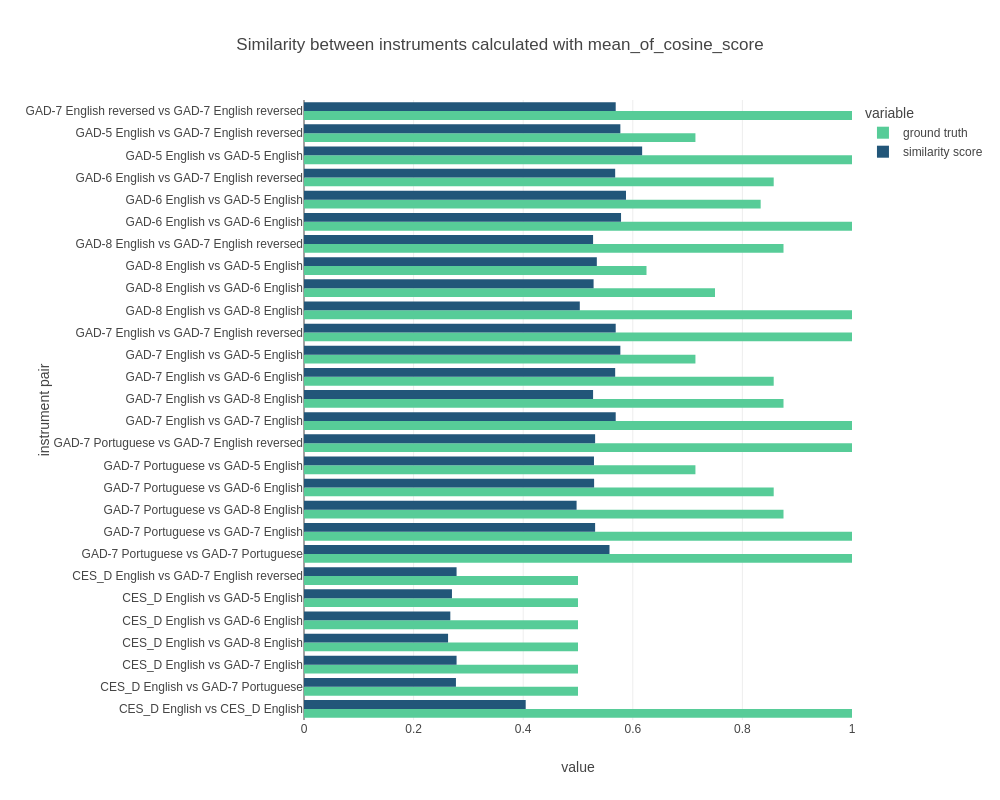

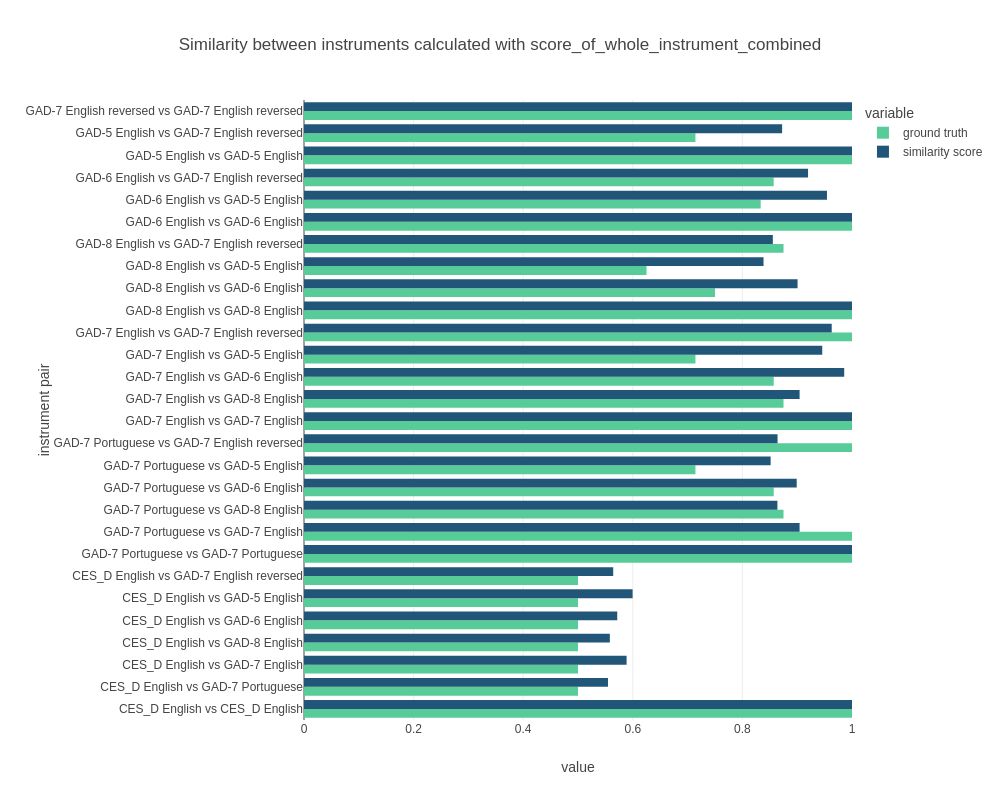

In [85]:
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

for similarity_function_name, subset in df_calculated_similarities.groupby("function"):

  fig = px.bar(data_frame=subset, y="instrument pair", barmode="group", x=["ground truth", "similarity score"], title=f"Similarity between instruments calculated with {similarity_function_name}")

  fig.update_yaxes(automargin=True)

  fig.update_layout(
      width=1000,
      height=800,
      xaxis={'range': [0, 1]}
  )
  fig.show(renderer="png")